---
skip_showdoc: true
---

# Introduction to the ERA 5 Data

The ERA5 dataset is the fifth iteration of the ECMWF ReAnalysis dataset, spanning from 1950 to the present. ECMWF is the "European Centre for Medium-Range Weather Forecasts".
The dataset provides comprehensive and high-resolution historical weather and climate data. The source data is from the [Copernicus Climate Data Store (CDS)](https://cds.climate.copernicus.eu/#!/home). A comprehensive data documentation guide is available [here](https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation). In total, the entire CDS ERA data is over 10Petabytes.

Fortunately for us, there are existing [Python](https://github.com/Climate-CAFE/era5-daily-heat-aggregation-python) and [R](https://github.com/Climate-CAFE/era5-daily-heat-aggregation) packages that have gone ahead and demonstrated extracting the data from the API for us, so we are going to use those to develop our workflow. Specifically, we're trying to understand the
following characteristics of the data:

* size, 
* how to download, 
* what are the key transformations to map things into the health sheds
* two important variables: 
    * 2m air temp, and, 
    * 2m air dew point

Let's get started


Important: we need to install the CDS API first, so you'll need to grab an API key. First, you must register for an account and accept the T&Cs, afterwhich the page [here](https://ecmwf-projects.github.io/copernicus-training-c3s/cds-tutorial.html#install-the-cds-api-key) will autopopulate an API key for you. The following code shows a test case to make sure your API key works

In [ ]:
import cdsapi

client = cdsapi.Client()

dataset = 'reanalysis-era5-pressure-levels'
request = {
  'product_type': ['reanalysis'],
  'variable': ['geopotential'],
  'year': ['2024'],
  'month': ['03'],
  'day': ['01'],
  'time': ['13:00'],
  'pressure_level': ['1000'],
  'data_format': 'grib',
}
target = 'download.grib'

client.retrieve(dataset, request, target)

2025-03-03 13:31:07,682 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 13:31:07,683 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 13:31:07,959 INFO Request ID is 07de689d-b7df-439b-b303-2214b8f3eec0
2025-03-03 13:31:08,091 INFO status has been updated to accepted
2025-03-03 13:34:00,781 INFO status has been updated to successful


1fd5a2b7ad40b8c614c78061a75d30d0.grib:   0%|          | 0.00/1.98M [00:00<?, ?B/s]

'download.grib'

This demonstration is expected to amass 9GB of data for raw raster files (24 years, 12 files per year). The demonstration generates the 24 years of heat measures across Kenya administrative boundaries, in 1-month periods of ERA5-Land data across Kenya with three variables (2-m temp, dew point temp, skin temp)

In [ ]:
# imports as recommended by the github repo
import cdsapi
import geopandas as gpd
import os


I'll use pyprojroot to specify a data path

In [ ]:
from pyprojroot.here import here

ecmw_dir = here("data")

In [ ]:
def create_dir(path):

    if not os.path.exists(path):
        os.makedirs(path)

    return path

In [ ]:
create_dir(ecmw_dir)

In [ ]:
# create a directory for the kenya data
create_dir(os.path.join(ecmw_dir, "Kenya_GADM"))

Next, we need to manually fetch this GADM file for Kenya from here: https://gadm.org/download_country.html

This is a boundaries geopackage; GeoBoundaries is a global database of administrative boundaries (e.g., countries, states, provinces, districts). Hence, this file provides the
boundaries for Kenyan regions

In [ ]:
kenya_shape =  gpd.read_file(os.path.join(ecmw_dir, "Kenya_GADM/gadm41_KEN.gpkg"), layer = "ADM_ADM_0")


In [ ]:
kenya_shape

,GID_0,COUNTRY,geometry
0,KEN,Kenya,"MULTIPOLYGON (((39.38014 -4.71792, 39.37986 -4..."


The bounding box represents the coordinates of the shapefile, which is what we'll
use to query Copernicus. Think of it like a mask provided in a file

In [ ]:
kenya_bbox = kenya_shape.total_bounds

In [ ]:
kenya_bbox

array([33.909588  , -4.720417  , 41.92621613,  5.06116581])

Technical: Add a small buffer around the bounding box to ensure the whole region 
is queried, and round the parameters to a 0.1 resolution. A 0.1 resolution
is applied because the resolution of netCDF ERA5 data is .25x.25
https://confluence.ecmwf.int/display/CKB/ERA5%3A+What+is+the+spatial+reference


In [ ]:
kenya_bbox[0] = round(kenya_bbox[0], 1) - 0.1
kenya_bbox[1] = round(kenya_bbox[1], 1) - 0.1
kenya_bbox[2] = round(kenya_bbox[2], 1) + 0.1
kenya_bbox[3] = round(kenya_bbox[3], 1) + 0.1

In [ ]:
# to build a query, specify [xmin, ymin, xmax, ymax]
query_area = [kenya_bbox[0], kenya_bbox[1], kenya_bbox[2], kenya_bbox[3]]

In [ ]:
query_years = list(range(2000, 2024))
query_years_str = [str(x) for x in query_years]

query_months = list(range(1, 13))
query_months_str = [str(x).zfill(2) for x in query_months]

In [ ]:
output_dir = create_dir(os.path.join(ecmw_dir, "ERA5_out"))

In [ ]:
for year_str in query_years_str:
    # Track progress
    print("Now processing year ", year_str, "\n")

    # For each year, the query is divided into each month sections. 
    # If a request is too large, it will not be accepted by the CDS servers, 
    # so this division of requests is required.

    for month_str in query_months_str:
        # Track progress
        print("Now processing month ", month_str, "\n")

        # The below is the formatted API request language. All of the inputs
        # specified below in proper formatting can be identified by forming a 
        # request using the Copernicus CDS point-and-click interface for data
        # requests. https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land?tab=form
        # Select the variables, timing, and netcdf as the output format, and then 
        # select "Show API Request" at the bottom of the screen. 
    
        # Note that the argument in the download() function is the file path and 
        # file name that data will be exported to and stored at. If using a loop, 
        # ensure that the unique features of each request are noted in the output.

        # Note: need to create "ERA5_Out" subfolder on your path
 
        dataset = "reanalysis-era5-land"
        request = {
                    "product_type": "reanalysis",
                    "variable": ["2m_dewpoint_temperature",
                                 "2m_temperature",
                                 "skin_temperature"], 
                    "year": year_str,
                    "month": month_str,
                    "day": [  
                            "01", "02", "03",
                            "04", "05", "06",
                            "07", "08", "09",
                            "10", "11", "12",
                            "13", "14", "15",
                            "16", "17", "18",
                            "19", "20", "21",
                            "22", "23", "24",
                            "25", "26", "27",
                            "28", "29", "30",
                            "31"],
                    "time": [
                             "00:00", "01:00", "02:00",
                             "03:00", "04:00", "05:00",
                             "06:00", "07:00", "08:00",
                             "09:00", "10:00", "11:00",
                             "12:00", "13:00", "14:00",
                             "15:00", "16:00", "17:00",
                             "18:00", "19:00", "20:00",
                             "21:00", "22:00", "23:00"],
                    "data_format": "netcdf",
                    "download_format": "unarchived",
                    "area": query_area
        }

        client = cdsapi.Client()
        client.retrieve(dataset, request).download(os.path.join(output_dir, 
                                                                "{}_{}.nc".format(year_str, month_str)))


Now processing year  2000 

Now processing month  01 



2025-03-03 13:52:06,896 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 13:52:06,897 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 13:52:07,181 INFO Request ID is 56d97887-22e9-441c-b33c-2236e5feaa87
2025-03-03 13:52:07,308 INFO status has been updated to accepted
2025-03-03 13:52:15,943 INFO status has been updated to successful


3f0a8829f1720f8fa1289e11eedada58.nc:   0%|          | 0.00/23.4M [00:00<?, ?B/s]

Now processing month  02 



2025-03-03 13:52:26,335 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 13:52:26,336 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 13:52:26,730 INFO Request ID is 02e31b6b-e047-4f4b-bf56-4eda01d5d08a
2025-03-03 13:52:27,070 INFO status has been updated to accepted
2025-03-03 13:52:36,181 INFO status has been updated to running
2025-03-03 14:02:50,214 INFO status has been updated to successful


bdfda68cb5ba4affec5b1f592ec6ed5f.nc:   0%|          | 0.00/20.3M [00:00<?, ?B/s]

Now processing month  03 



2025-03-03 14:02:56,179 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 14:02:56,180 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 14:02:56,555 INFO Request ID is 3e4ebcbc-7038-43b4-927b-b4ce291fd60f
2025-03-03 14:02:56,703 INFO status has been updated to accepted
2025-03-03 14:03:18,825 INFO status has been updated to running
2025-03-03 14:11:18,070 INFO status has been updated to successful


eadfd863f7f6a6f82d1f077b6f137cdf.nc:   0%|          | 0.00/24.4M [00:00<?, ?B/s]

Now processing month  04 



2025-03-03 14:11:27,837 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 14:11:27,838 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 14:11:28,199 INFO Request ID is f2a01b32-4853-4d2d-a873-9986d4c668fa
2025-03-03 14:11:28,358 INFO status has been updated to accepted
2025-03-03 14:11:33,798 INFO status has been updated to running
2025-03-03 14:17:48,663 INFO status has been updated to successful


7790b627e1ed17c07398e4943ddc66f8.nc:   0%|          | 0.00/20.2M [00:00<?, ?B/s]

Now processing month  05 



2025-03-03 14:17:54,131 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 14:17:54,132 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 14:17:54,453 INFO Request ID is 1cf8b1bc-ba8b-4865-a895-1634b22b0cb0
2025-03-03 14:17:54,572 INFO status has been updated to accepted
2025-03-03 14:18:03,340 INFO status has been updated to running
2025-03-03 14:24:14,619 INFO status has been updated to successful


af8da5f83b8f4edfcfdc9e9b01e85167.nc:   0%|          | 0.00/22.7M [00:00<?, ?B/s]

Now processing month  06 



2025-03-03 14:24:18,644 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 14:24:18,645 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 14:24:18,893 INFO Request ID is 8d9297fa-d2d6-4cf8-8473-669175f205a6
2025-03-03 14:24:19,004 INFO status has been updated to accepted
2025-03-03 14:24:27,645 INFO status has been updated to running
2025-03-03 14:30:40,248 INFO status has been updated to successful


f222a9f45eec1093306d1f8bbf9bbdd2.nc:   0%|          | 0.00/21.5M [00:00<?, ?B/s]

Now processing month  07 



2025-03-03 14:30:45,830 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 14:30:45,832 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 14:30:46,161 INFO Request ID is 13f963a5-df07-42b0-9535-40f5dd511890
2025-03-03 14:30:46,284 INFO status has been updated to accepted
2025-03-03 14:30:54,964 INFO status has been updated to running
2025-03-03 14:37:06,377 INFO status has been updated to successful


a56370ec686f31437a5c9328b74e48da.nc:   0%|          | 0.00/22.8M [00:00<?, ?B/s]

Now processing month  08 



2025-03-03 14:37:13,309 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 14:37:13,310 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 14:37:13,713 INFO Request ID is 33d25bd3-d6a3-4faa-8b21-7e9d93faf9f2
2025-03-03 14:37:13,869 INFO status has been updated to accepted
2025-03-03 14:37:22,628 INFO status has been updated to running
2025-03-03 14:41:33,768 INFO status has been updated to successful


a393f6cb418b557a044ef0b4e0fb3b68.nc:   0%|          | 0.00/22.7M [00:00<?, ?B/s]

Now processing month  09 



2025-03-03 14:41:37,733 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 14:41:37,734 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 14:41:38,015 INFO Request ID is bc09a8e9-669b-4d05-85c4-e4cf6f0cc897
2025-03-03 14:41:38,137 INFO status has been updated to accepted
2025-03-03 14:41:46,811 INFO status has been updated to running
2025-03-03 14:51:58,738 INFO status has been updated to successful


53d56522c26bfa010f95b2a567bfba6b.nc:   0%|          | 0.00/21.7M [00:00<?, ?B/s]

Now processing month  10 



2025-03-03 14:52:02,100 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 14:52:02,100 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 14:52:02,388 INFO Request ID is 241ee8b5-f821-40e3-85a2-8409879e70f9
2025-03-03 14:52:02,514 INFO status has been updated to accepted
2025-03-03 14:52:16,437 INFO status has been updated to running
2025-03-03 15:00:13,552 INFO status has been updated to successful


f7c843ccd2d84ceb1b96e518a6aa2700.nc:   0%|          | 0.00/23.8M [00:00<?, ?B/s]

Now processing month  11 



2025-03-03 15:00:27,786 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 15:00:27,788 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 15:00:28,099 INFO Request ID is 8105daba-e0c3-4645-99cb-5cfe48933195
2025-03-03 15:00:28,306 INFO status has been updated to accepted
2025-03-03 15:00:42,459 INFO status has been updated to running
2025-03-03 15:04:48,209 INFO status has been updated to successful


48275b1e8bd062eebd8362a189661294.nc:   0%|          | 0.00/20.2M [00:00<?, ?B/s]

Now processing month  12 



2025-03-03 15:04:52,699 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 15:04:52,700 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 15:04:53,116 INFO Request ID is dd89e23a-cada-48d1-8c5f-4792a907f6c0
2025-03-03 15:04:53,231 INFO status has been updated to accepted
2025-03-03 15:05:07,118 INFO status has been updated to running
2025-03-03 15:11:13,173 INFO status has been updated to successful


63a09f7c91b0eee81c2abc276659ff0.nc:   0%|          | 0.00/22.8M [00:00<?, ?B/s]

Now processing year  2001 

Now processing month  01 



2025-03-03 15:11:17,671 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 15:11:17,672 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 15:11:18,119 INFO Request ID is d39ace79-6b2b-46f1-9dfc-97a95c08be81
2025-03-03 15:11:18,254 INFO status has been updated to accepted
2025-03-03 15:11:27,207 INFO status has been updated to running
2025-03-03 15:17:38,525 INFO status has been updated to successful


a6f5c95b97ba2a5ea63d74168362d060.nc:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

Now processing month  02 



2025-03-03 15:17:43,072 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 15:17:43,073 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 15:17:43,421 INFO Request ID is 24a2df52-8ea9-47b6-bd22-8e3bdb4abc41
2025-03-03 15:17:43,550 INFO status has been updated to accepted
2025-03-03 15:17:52,171 INFO status has been updated to running
2025-03-03 15:22:03,113 INFO status has been updated to successful


7353a6681620a6ac4e57207c4c34cf7e.nc:   0%|          | 0.00/19.2M [00:00<?, ?B/s]

Now processing month  03 



2025-03-03 15:22:06,759 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 15:22:06,759 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 15:22:07,172 INFO Request ID is 83ad483b-c8ad-4626-9ed2-49df53bca636
2025-03-03 15:22:07,283 INFO status has been updated to accepted
2025-03-03 15:22:15,995 INFO status has been updated to running
2025-03-03 15:26:27,325 INFO status has been updated to successful


b49dba0c41e7c7174ed705b77edab42.nc:   0%|          | 0.00/23.4M [00:00<?, ?B/s]

Now processing month  04 



2025-03-03 15:26:33,108 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 15:26:33,109 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 15:26:33,462 INFO Request ID is c07a211a-40ef-4b0a-b63e-605127309fa3
2025-03-03 15:26:33,603 INFO status has been updated to accepted
2025-03-03 15:26:42,257 INFO status has been updated to running
2025-03-03 15:30:53,083 INFO status has been updated to successful


53bf46ff597b3d357606e8cae56c470a.nc:   0%|          | 0.00/20.4M [00:00<?, ?B/s]

Now processing month  05 



2025-03-03 15:30:56,589 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 15:30:56,591 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 15:30:56,905 INFO Request ID is ca147122-6e94-4fd4-a20b-ee88ec92653f
2025-03-03 15:30:57,038 INFO status has been updated to accepted
2025-03-03 15:31:05,718 INFO status has been updated to running
2025-03-03 15:35:16,989 INFO status has been updated to successful


c155f6e8757b8648c1ce728eaa1f0866.nc:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

Now processing month  06 



2025-03-03 15:35:21,024 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 15:35:21,025 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 15:35:21,366 INFO Request ID is d335b374-1775-4614-97a4-5a3821e02309
2025-03-03 15:35:21,490 INFO status has been updated to accepted
2025-03-03 15:35:30,131 INFO status has been updated to running
2025-03-03 15:41:41,797 INFO status has been updated to successful


6146d7b9b2da8097fbe3021e1682cfa0.nc:   0%|          | 0.00/21.6M [00:00<?, ?B/s]

Now processing month  07 



2025-03-03 15:41:45,590 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 15:41:45,591 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 15:41:45,881 INFO Request ID is 9a7bd182-69d5-462c-a4ab-b9785f1378da
2025-03-03 15:41:46,002 INFO status has been updated to accepted
2025-03-03 15:41:54,620 INFO status has been updated to running
2025-03-03 15:50:06,189 INFO status has been updated to successful


e2b5d31f1e484f56cbcc8ef7eaa61941.nc:   0%|          | 0.00/22.8M [00:00<?, ?B/s]

Now processing month  08 



2025-03-03 15:50:09,722 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 15:50:09,723 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 15:50:10,010 INFO Request ID is 12d44164-5b53-44d1-b59e-8014fc094cf1
2025-03-03 15:50:10,148 INFO status has been updated to accepted
2025-03-03 15:50:15,289 INFO status has been updated to running
2025-03-03 15:58:30,547 INFO status has been updated to successful


edd45e6f0ef2cca4d8eacbffd0965bbb.nc:   0%|          | 0.00/23.8M [00:00<?, ?B/s]

Now processing month  09 



2025-03-03 15:58:34,164 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 15:58:34,165 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 15:58:34,507 INFO Request ID is 47938f42-99b6-4950-b016-9d26a52a1c58
2025-03-03 15:58:34,631 INFO status has been updated to accepted
2025-03-03 15:58:43,316 INFO status has been updated to running
2025-03-03 16:04:54,992 INFO status has been updated to successful


57793eca83ae1a510eed0c349ee3ec86.nc:   0%|          | 0.00/21.7M [00:00<?, ?B/s]

Now processing month  10 



2025-03-03 16:04:59,087 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 16:04:59,087 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 16:04:59,386 INFO Request ID is 181de390-2ee5-4f22-9e30-eee697fa6cfb
2025-03-03 16:04:59,600 INFO status has been updated to accepted
2025-03-03 16:05:08,251 INFO status has been updated to running
2025-03-03 16:09:19,270 INFO status has been updated to successful


df861e01490f4bb9f2b017dddbeb4c9a.nc:   0%|          | 0.00/23.1M [00:00<?, ?B/s]

Now processing month  11 



2025-03-03 16:09:24,093 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 16:09:24,093 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 16:09:24,402 INFO Request ID is 05046ebf-a981-4608-a637-69fbf0be52c6
2025-03-03 16:09:24,530 INFO status has been updated to accepted
2025-03-03 16:09:33,211 INFO status has been updated to running
2025-03-03 16:15:45,215 INFO status has been updated to successful


cc92abb473270b684e4311a89ea223b8.nc:   0%|          | 0.00/21.7M [00:00<?, ?B/s]

Now processing month  12 



2025-03-03 16:15:48,551 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 16:15:48,552 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 16:15:48,865 INFO Request ID is 78c4cfb8-5e49-409b-af59-5aaea12c7443
2025-03-03 16:15:49,009 INFO status has been updated to accepted
2025-03-03 16:15:57,626 INFO status has been updated to running
2025-03-03 16:22:09,151 INFO status has been updated to successful


4030d07d1ca90f940aaf0bcdbbfc9a69.nc:   0%|          | 0.00/23.7M [00:00<?, ?B/s]

Now processing year  2002 

Now processing month  01 



2025-03-03 16:22:14,128 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 16:22:14,128 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 16:22:14,432 INFO Request ID is 8ee4bafd-9b6e-4884-948a-eb86a903be4b
2025-03-03 16:22:14,563 INFO status has been updated to accepted
2025-03-03 16:22:23,215 INFO status has been updated to running
2025-03-03 16:28:34,713 INFO status has been updated to successful


4952a6018fe09831b536f02cc68cfdaa.nc:   0%|          | 0.00/22.7M [00:00<?, ?B/s]

Now processing month  02 



2025-03-03 16:28:38,466 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 16:28:38,468 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 16:28:38,748 INFO Request ID is 7e7c46c6-7e33-4456-bb84-ab6abd905e73
2025-03-03 16:28:38,899 INFO status has been updated to accepted
2025-03-03 16:28:47,557 INFO status has been updated to running
2025-03-03 16:34:58,844 INFO status has been updated to successful


746bfeac4672f082014b9bfc8629e0fc.nc:   0%|          | 0.00/19.5M [00:00<?, ?B/s]

Now processing month  03 



2025-03-03 16:35:02,056 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 16:35:02,057 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 16:35:02,383 INFO Request ID is a1dbd535-ef6a-4ff8-843a-dc380bbfd9fc
2025-03-03 16:35:02,490 INFO status has been updated to accepted
2025-03-03 16:35:12,020 INFO status has been updated to running
2025-03-03 16:41:23,295 INFO status has been updated to successful


f0aa24727636a12faf9e051c128a6dbf.nc:   0%|          | 0.00/23.8M [00:00<?, ?B/s]

Now processing month  04 



2025-03-03 16:41:26,983 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 16:41:26,983 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 16:41:27,339 INFO Request ID is 169d5b0c-53e0-422a-a99b-753cb770b553
2025-03-03 16:41:27,473 INFO status has been updated to accepted
2025-03-03 16:41:32,657 INFO status has been updated to running
2025-03-03 16:47:47,676 INFO status has been updated to successful


1139875c53f8ba5a2279763e094e82dd.nc:   0%|          | 0.00/20.1M [00:00<?, ?B/s]

Now processing month  05 



2025-03-03 16:47:53,627 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 16:47:53,629 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 16:47:53,949 INFO Request ID is e057a82f-26c1-49c2-86d2-e803f4e609b9
2025-03-03 16:47:54,149 INFO status has been updated to accepted
2025-03-03 16:47:59,351 INFO status has been updated to running
2025-03-03 16:54:14,219 INFO status has been updated to successful


e6cd334a734633bf2677a41b64ef0503.nc:   0%|          | 0.00/22.8M [00:00<?, ?B/s]

Now processing month  06 



2025-03-03 16:54:17,476 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 16:54:17,477 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 16:54:17,808 INFO Request ID is 57f52ced-a466-46f7-8e89-60962b0b1e71
2025-03-03 16:54:17,962 INFO status has been updated to accepted
2025-03-03 16:54:26,612 INFO status has been updated to running
2025-03-03 17:04:38,619 INFO status has been updated to successful


c549e11cbe2ac4ea745dfee071d5477c.nc:   0%|          | 0.00/21.5M [00:00<?, ?B/s]

Now processing month  07 



2025-03-03 17:04:41,945 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 17:04:41,947 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 17:04:42,262 INFO Request ID is 0c4a12a8-9e3f-4479-903c-12218d4995cc
2025-03-03 17:04:42,395 INFO status has been updated to accepted
2025-03-03 17:04:56,207 INFO status has been updated to running
2025-03-03 17:11:02,228 INFO status has been updated to successful


4910d00a419d7e9af6772646a37c5ef2.nc:   0%|          | 0.00/22.8M [00:00<?, ?B/s]

Now processing month  08 



2025-03-03 17:11:05,552 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 17:11:05,553 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 17:11:05,923 INFO Request ID is 2a14a8a9-72bb-4ad5-be7b-66ea35cc5f78
2025-03-03 17:11:06,092 INFO status has been updated to accepted
2025-03-03 17:11:19,956 INFO status has been updated to running
2025-03-03 17:17:26,215 INFO status has been updated to successful


df18b33085c197ddb5ead7aad67e32ea.nc:   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Now processing month  09 



2025-03-03 17:17:40,447 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 17:17:40,448 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 17:17:40,911 INFO Request ID is ab2a6b15-0383-4bda-877a-38c400783092
2025-03-03 17:17:41,098 INFO status has been updated to accepted
2025-03-03 17:17:49,765 INFO status has been updated to running
2025-03-03 17:24:01,146 INFO status has been updated to successful


24747fb2834f85bc2bc161a526047576.nc:   0%|          | 0.00/21.3M [00:00<?, ?B/s]

Now processing month  10 



2025-03-03 17:24:05,314 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 17:24:05,315 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 17:24:05,613 INFO Request ID is 2222bf20-78ae-480b-8866-d04fb0ebd22b
2025-03-03 17:24:05,723 INFO status has been updated to accepted
2025-03-03 17:24:14,410 INFO status has been updated to running
2025-03-03 17:28:25,275 INFO status has been updated to successful


4a0047e55e40631d4257bc999430f369.nc:   0%|          | 0.00/22.8M [00:00<?, ?B/s]

Now processing month  11 



2025-03-03 17:28:28,643 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 17:28:28,644 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 17:28:28,930 INFO Request ID is 4247b9db-0eb8-4dd4-bea7-71a188cd7191
2025-03-03 17:28:29,062 INFO status has been updated to accepted
2025-03-03 17:28:37,733 INFO status has been updated to running
2025-03-03 17:34:48,991 INFO status has been updated to successful


83f38bf86f197534418c3f793d00df51.nc:   0%|          | 0.00/20.2M [00:00<?, ?B/s]

Now processing month  12 



2025-03-03 17:34:52,520 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 17:34:52,520 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 17:34:52,853 INFO Request ID is 54b41ffd-5411-438b-9209-5a1a48e726f2
2025-03-03 17:34:52,983 INFO status has been updated to accepted
2025-03-03 17:35:01,605 INFO status has been updated to running
2025-03-03 17:41:12,968 INFO status has been updated to successful


c548caeddfbc3b57a873757af31bb3f2.nc:   0%|          | 0.00/22.6M [00:00<?, ?B/s]

Now processing year  2003 

Now processing month  01 



2025-03-03 17:41:16,083 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 17:41:16,084 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 17:41:16,395 INFO Request ID is da7f6ab3-f9a4-4cf4-a336-8d4c6069eab6
2025-03-03 17:41:16,530 INFO status has been updated to accepted
2025-03-03 17:41:25,165 INFO status has been updated to running
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Max retries exceeded with url: /api/retrieve/v1/jobs/da7f6ab3-f9a4-4cf4-a336-8d4c6069eab6?log=True&request=True (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object>: Failed to resolve 'cds.climate.copernicus.eu' ([Errno 8]

9cbcabcbc8259ee36e1d9c27c7bcd2e5.nc:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Now processing month  02 



2025-03-03 18:41:15,737 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 18:41:15,738 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 18:41:16,175 INFO Request ID is 4516d2f1-5b65-4107-b5b8-4ce4d95e348a
2025-03-03 18:41:16,336 INFO status has been updated to accepted
2025-03-03 18:41:25,142 INFO status has been updated to running
2025-03-03 18:45:36,530 INFO status has been updated to successful


18bd057dcbf50d7d98976cc045d62028.nc:   0%|          | 0.00/19.3M [00:00<?, ?B/s]

Now processing month  03 



2025-03-03 18:45:39,813 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 18:45:39,813 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 18:45:40,206 INFO Request ID is 34d46db0-4d01-40bd-b373-8162efa32401
2025-03-03 18:45:40,364 INFO status has been updated to accepted
2025-03-03 18:45:49,388 INFO status has been updated to running
2025-03-03 18:52:02,740 INFO status has been updated to successful


322964381fe45a66af5c5413fbf5644a.nc:   0%|          | 0.00/23.3M [00:00<?, ?B/s]

Now processing month  04 



2025-03-03 18:52:11,330 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 18:52:11,331 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 18:52:11,722 INFO Request ID is 4d879f72-cb55-4254-aa16-5a72ef43d23c
2025-03-03 18:52:11,883 INFO status has been updated to accepted
2025-03-03 18:52:20,741 INFO status has been updated to running
2025-03-03 18:58:32,697 INFO status has been updated to successful


9ae86c78223efe1a0ac750a2a221fc6d.nc:   0%|          | 0.00/21.7M [00:00<?, ?B/s]

Now processing month  05 



2025-03-03 18:58:55,948 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 18:58:55,949 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 18:58:56,566 INFO Request ID is 6e70abd1-da04-4fb4-b969-e4048d40ef03
2025-03-03 18:58:56,721 INFO status has been updated to accepted
2025-03-03 18:59:10,952 INFO status has been updated to running
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attemps 1 of 500
Retrying in 120 seconds
2025-03-03 20:16:37,571 INFO status has been updated to successful


77351793564a16788bd9ff4ff003f15e.nc:   0%|          | 0.00/24.0M [00:00<?, ?B/s]

Now processing month  06 



2025-03-03 20:16:41,181 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 20:16:41,182 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 20:16:41,558 INFO Request ID is c5b24a83-481b-4e13-8662-3174a3cc8038
2025-03-03 20:16:41,704 INFO status has been updated to accepted
2025-03-03 20:16:55,758 INFO status has been updated to running
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attemps 1 of 500
Retrying in 120 seconds
2025-03-03 21:54:10,191 INFO status has been updated to successful


7f99b74ab25ed4e8b5c181262f90162b.nc:   0%|          | 0.00/21.1M [00:00<?, ?B/s]

Now processing month  07 



2025-03-03 21:54:13,686 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 21:54:13,687 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 21:54:14,053 INFO Request ID is aa63909b-dd55-4b50-9109-d97101407bb4
2025-03-03 21:54:14,221 INFO status has been updated to accepted
2025-03-03 21:54:23,021 INFO status has been updated to running
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attemps 1 of 500
Retrying in 120 seconds
2025-03-03 22:46:05,448 INFO status has been updated to successful


b5f4942e64b0f955a2a693d1e5bdbc64.nc:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Now processing month  08 



2025-03-03 22:46:15,545 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-03 22:46:15,547 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-03 22:46:15,927 INFO Request ID is 20adab3a-13d3-4718-9b95-1545745ac571
2025-03-03 22:46:16,445 INFO status has been updated to accepted
2025-03-03 22:46:21,698 INFO status has been updated to running
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attemps 1 of 500
Retrying in 120 seconds
2025-03-04 00:21:52,696 INFO status has been updated to successful


d4ff59b4ec3fda00d4074896dbcb7bc.nc:   0%|          | 0.00/23.8M [00:00<?, ?B/s]

Now processing month  09 



2025-03-04 00:22:07,044 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 00:22:07,059 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 00:22:07,433 INFO Request ID is 9e1dad3f-786e-4f36-8f48-a3d8b0e3d291
2025-03-04 00:22:07,590 INFO status has been updated to accepted
2025-03-04 00:22:16,404 INFO status has been updated to running
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attemps 1 of 500
Retrying in 120 seconds
2025-03-04 03:10:29,610 INFO status has been updated to successful


132b6164c0ca36daaf324f4207628ff0.nc:   0%|          | 0.00/21.7M [00:00<?, ?B/s]

Now processing month  10 



2025-03-04 03:10:33,344 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 03:10:33,344 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 03:10:33,702 INFO Request ID is 59d7b1b3-5a6c-4305-bec5-84d8a54588d2
2025-03-04 03:10:33,859 INFO status has been updated to accepted
2025-03-04 03:10:39,118 INFO status has been updated to running
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attemps 1 of 500
Retrying in 120 seconds
2025-03-04 04:48:49,216 INFO status has been updated to successful


a555c239db00bc554d8244e8ad695672.nc:   0%|          | 0.00/23.1M [00:00<?, ?B/s]

Now processing month  11 



2025-03-04 04:48:53,323 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 04:48:53,324 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 04:48:53,679 INFO Request ID is 16f644ad-e849-4a58-8214-d2e620a096e4
2025-03-04 04:48:53,848 INFO status has been updated to accepted
2025-03-04 04:48:59,101 INFO status has been updated to running
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attemps 1 of 500
Retrying in 120 seconds
2025-03-04 06:27:39,088 INFO status has been updated to successful


2f4822e1cbe36b79a3992ad7f01f4214.nc:   0%|          | 0.00/21.3M [00:00<?, ?B/s]

Now processing month  12 



2025-03-04 06:27:49,122 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 06:27:49,123 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 06:27:49,516 INFO Request ID is 45635b7d-1128-402c-99ec-8a0ad7814c83
2025-03-04 06:27:49,722 INFO status has been updated to accepted
2025-03-04 06:27:55,019 INFO status has been updated to running
2025-03-04 06:28:04,209 INFO status has been updated to accepted
2025-03-04 06:28:12,005 INFO status has been updated to running
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attemps 1 of 500
Retrying in 120 seconds
2025-03-04 08:01:27,064 INFO status has

4bd60f841fa47583f79fc66a8401d0ad.nc:   0%|          | 0.00/22.7M [00:00<?, ?B/s]

Now processing year  2004 

Now processing month  01 



2025-03-04 08:01:32,319 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 08:01:32,320 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 08:01:33,516 INFO Request ID is bb759952-18b4-48d9-8d0e-954362686a6a
2025-03-04 08:01:33,677 INFO status has been updated to accepted
2025-03-04 08:01:38,967 INFO status has been updated to running
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attemps 1 of 500
Retrying in 120 seconds
2025-03-04 09:38:12,083 INFO status has been updated to successful


d4f4e4aeb1a9248692853a5c3efbf89.nc:   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Recovering from connection error [HTTPSConnectionPool(host='object-store.os-api.cci2.ecmwf.int', port=443): Read timed out.], attemps 1 of 500
Retrying in 120 seconds


d4f4e4aeb1a9248692853a5c3efbf89.nc:   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Now processing month  02 



2025-03-04 09:47:43,625 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 09:47:43,626 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 09:47:43,900 INFO Request ID is e3420e1c-4f8d-4251-964c-2e001a220819
2025-03-04 09:47:44,024 INFO status has been updated to accepted
2025-03-04 09:47:49,179 INFO status has been updated to running
2025-03-04 09:54:04,081 INFO status has been updated to successful


6e51aaba6e9e394aec2c472dba256e72.nc:   0%|          | 0.00/20.3M [00:00<?, ?B/s]

Now processing month  03 



2025-03-04 09:54:10,509 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 09:54:10,510 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 09:54:10,838 INFO Request ID is beb2cc9b-50ba-4385-885a-74f82cd85646
2025-03-04 09:54:11,012 INFO status has been updated to accepted
2025-03-04 09:54:16,257 INFO status has been updated to running
2025-03-04 10:02:32,275 INFO status has been updated to successful


577113643e225204be90c7d41e3255c1.nc:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Now processing month  04 



2025-03-04 10:02:36,182 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 10:02:36,183 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 10:02:36,590 INFO Request ID is 0485dce7-9b91-4e4d-b46a-57c9dcb2acca
2025-03-04 10:02:36,721 INFO status has been updated to accepted
2025-03-04 10:02:45,458 INFO status has been updated to running
2025-03-04 10:08:57,057 INFO status has been updated to successful


b15d5bde5ff8d58b65a653eb30e811bc.nc:   0%|          | 0.00/20.4M [00:00<?, ?B/s]

Now processing month  05 



2025-03-04 10:09:02,921 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 10:09:02,922 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 10:09:03,198 INFO Request ID is 6ee8d338-0f4e-4f05-a394-18607c0edb9d
2025-03-04 10:09:03,336 INFO status has been updated to accepted
2025-03-04 10:09:18,215 INFO status has been updated to running
2025-03-04 10:15:24,462 INFO status has been updated to successful


e9d63b8d3e4766add5c9adda544ffb77.nc:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Now processing month  06 



2025-03-04 10:15:29,851 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 10:15:29,852 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 10:15:30,148 INFO Request ID is ad2bfc81-e9d2-4a1b-bb03-eee097b8ebff
2025-03-04 10:15:30,286 INFO status has been updated to accepted
2025-03-04 10:15:35,440 INFO status has been updated to running
2025-03-04 10:21:50,350 INFO status has been updated to successful


d4e93dc9a851bdcd8ae7c4f4fa7b61d9.nc:   0%|          | 0.00/20.3M [00:00<?, ?B/s]

Now processing month  07 



2025-03-04 10:21:56,973 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 10:21:56,974 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 10:21:57,348 INFO Request ID is 93a6680d-baa9-49e7-9a29-4224f5e24de2
2025-03-04 10:21:57,495 INFO status has been updated to accepted
2025-03-04 10:22:02,865 INFO status has been updated to running
2025-03-04 10:22:11,652 INFO status has been updated to accepted
2025-03-04 10:22:19,406 INFO status has been updated to running
2025-03-04 10:28:17,758 INFO status has been updated to successful


75ff3e1ccd6f92b7d8c8dbdd7d4ae92d.nc:   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Now processing month  08 



2025-03-04 10:28:24,118 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 10:28:24,119 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 10:28:24,440 INFO Request ID is a70f92e0-ec80-493a-8b6a-41fa00b00119
2025-03-04 10:28:24,574 INFO status has been updated to accepted
2025-03-04 10:28:33,356 INFO status has been updated to running
2025-03-04 10:34:44,894 INFO status has been updated to successful


4a6b2d7d1cb2482b423c99751d84a34d.nc:   0%|          | 0.00/23.7M [00:00<?, ?B/s]

Now processing month  09 



2025-03-04 10:34:48,913 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 10:34:48,913 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 10:34:49,247 INFO Request ID is 8462b2cd-cd64-4afb-a331-929d6c36b6d3
2025-03-04 10:34:49,385 INFO status has been updated to accepted
2025-03-04 10:35:03,181 INFO status has been updated to running
2025-03-04 10:41:09,230 INFO status has been updated to successful


6b2313ffa46bdca1e1b8a0272157602c.nc:   0%|          | 0.00/20.4M [00:00<?, ?B/s]

Now processing month  10 



2025-03-04 10:41:18,443 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 10:41:18,443 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 10:41:18,803 INFO Request ID is 9c4e4872-cc6d-4c69-b5e5-5e9611545f92
2025-03-04 10:41:18,955 INFO status has been updated to accepted
2025-03-04 10:41:27,708 INFO status has been updated to running
2025-03-04 10:47:40,234 INFO status has been updated to successful


e69b8907411d58169a4757de7beb788c.nc:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Now processing month  11 



2025-03-04 10:47:46,398 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 10:47:46,399 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 10:47:46,722 INFO Request ID is f9da7b12-259e-4213-ad8f-b09b805176a3
2025-03-04 10:47:46,844 INFO status has been updated to accepted
2025-03-04 10:48:08,549 INFO status has been updated to running
2025-03-04 10:54:06,935 INFO status has been updated to successful


fba17f50666c361d8f4774e5e8c3d6aa.nc:   0%|          | 0.00/21.1M [00:00<?, ?B/s]

Now processing month  12 



2025-03-04 10:54:12,500 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 10:54:12,501 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 10:54:12,796 INFO Request ID is 5d529887-5804-4e3e-8bfb-2a1a936f531e
2025-03-04 10:54:13,007 INFO status has been updated to accepted
2025-03-04 10:54:18,251 INFO status has been updated to running
2025-03-04 11:00:33,100 INFO status has been updated to successful


3e0cb42efea037099b66d46828f8d149.nc:   0%|          | 0.00/23.3M [00:00<?, ?B/s]

Now processing year  2005 

Now processing month  01 



2025-03-04 11:00:37,145 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 11:00:37,146 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 11:00:37,503 INFO Request ID is a40e8775-d8b4-499e-baa7-f564cd05123c
2025-03-04 11:00:37,635 INFO status has been updated to accepted
2025-03-04 11:00:46,318 INFO status has been updated to running
2025-03-04 11:06:57,519 INFO status has been updated to successful


100dc6b3e4ef04c0b33734cde7d11ca5.nc:   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Now processing month  02 



2025-03-04 11:07:01,610 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 11:07:01,611 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 11:07:02,019 INFO Request ID is 03fdd916-29b5-4d4e-923f-19e3bd66bca1
2025-03-04 11:07:02,130 INFO status has been updated to accepted
2025-03-04 11:07:23,700 INFO status has been updated to running
2025-03-04 11:13:22,011 INFO status has been updated to successful


82f6b0ec92e3083461af35420a4356b9.nc:   0%|          | 0.00/19.6M [00:00<?, ?B/s]

Now processing month  03 



2025-03-04 11:13:26,175 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 11:13:26,176 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 11:13:26,462 INFO Request ID is dcf86bd8-5951-47eb-833b-f9971bf3f587
2025-03-04 11:13:26,587 INFO status has been updated to accepted
2025-03-04 11:13:31,737 INFO status has been updated to running
2025-03-04 11:19:46,761 INFO status has been updated to successful


5ca6b0c8145b049c15ae44413de55d25.nc:   0%|          | 0.00/22.8M [00:00<?, ?B/s]

Now processing month  04 



2025-03-04 11:19:53,689 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 11:19:53,690 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 11:19:54,001 INFO Request ID is 005fbc44-a1d1-4b23-ad05-0cd81f88ffea
2025-03-04 11:19:54,132 INFO status has been updated to accepted
2025-03-04 11:20:27,373 INFO status has been updated to running
2025-03-04 11:32:15,333 INFO status has been updated to successful


ffc02554880287503940142e8a510d4a.nc:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

Now processing month  05 



2025-03-04 11:32:19,220 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 11:32:19,222 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 11:32:19,570 INFO Request ID is 6bb5e9c7-9b29-41ea-a109-389b8d991ac0
2025-03-04 11:32:19,744 INFO status has been updated to accepted
2025-03-04 11:42:40,683 INFO status has been updated to running
2025-03-04 11:48:41,817 INFO status has been updated to successful


8f252a394e01bee76c3963e6dd84b52e.nc:   0%|          | 0.00/21.9M [00:00<?, ?B/s]

Now processing month  06 



2025-03-04 11:48:47,592 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 11:48:47,592 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 11:48:47,914 INFO Request ID is 724fe9e0-d76b-42ba-8c5a-f38589b1efeb
2025-03-04 11:48:48,047 INFO status has been updated to accepted
2025-03-04 12:09:12,266 INFO status has been updated to running
2025-03-04 12:15:13,455 INFO status has been updated to successful


17d0d4b440635e196965c85a437e0f98.nc:   0%|          | 0.00/20.3M [00:00<?, ?B/s]

Now processing month  07 



2025-03-04 12:15:19,513 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 12:15:19,514 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 12:15:19,816 INFO Request ID is 3a4657cf-d697-48da-83ea-d110a50fd5e3
2025-03-04 12:15:19,949 INFO status has been updated to accepted
2025-03-04 12:27:41,331 INFO status has been updated to running
2025-03-04 12:33:43,172 INFO status has been updated to successful


3462d7892fbf021e487d38ff00ea729f.nc:   0%|          | 0.00/22.2M [00:00<?, ?B/s]

Now processing month  08 



2025-03-04 12:33:53,005 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 12:33:53,006 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 12:33:53,308 INFO Request ID is d92c960f-bf32-43f7-becb-1a8c2023442a
2025-03-04 12:33:53,430 INFO status has been updated to accepted
2025-03-04 12:40:13,337 INFO status has been updated to running
2025-03-04 12:46:14,388 INFO status has been updated to successful


6f115164f9f9eb7585681eea3410cc27.nc:   0%|          | 0.00/23.8M [00:00<?, ?B/s]

Now processing month  09 



2025-03-04 12:47:32,769 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 12:47:32,770 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 12:47:33,094 INFO Request ID is a128253d-b7b4-4b64-8a56-de57091c5433
2025-03-04 12:47:33,525 INFO status has been updated to accepted
2025-03-04 12:47:42,430 INFO status has been updated to running
2025-03-04 12:53:54,370 INFO status has been updated to successful


a4366d50b0870de70d4c225f8b69a97.nc:   0%|          | 0.00/21.5M [00:00<?, ?B/s]

Now processing month  10 



2025-03-04 12:54:02,725 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 12:54:02,725 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 12:54:03,069 INFO Request ID is 6587609e-a8d7-4dde-a82d-5869f63c94a0
2025-03-04 12:54:03,186 INFO status has been updated to accepted
2025-03-04 12:54:24,878 INFO status has been updated to running
2025-03-04 13:02:24,112 INFO status has been updated to successful


5bec83b48bd3580b8b513169027b6201.nc:   0%|          | 0.00/23.3M [00:00<?, ?B/s]

Now processing month  11 



2025-03-04 13:02:33,128 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 13:02:33,129 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 13:02:33,548 INFO Request ID is 4158b3e1-5c5b-4695-b4c6-ca3e14184cc7
2025-03-04 13:02:33,721 INFO status has been updated to accepted
2025-03-04 13:05:26,404 INFO status has been updated to running
2025-03-04 13:10:53,924 INFO status has been updated to successful


24b332ae08734d20c69fd626bf6f87d0.nc:   0%|          | 0.00/20.3M [00:00<?, ?B/s]

Now processing month  12 



2025-03-04 13:10:59,388 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 13:10:59,388 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 13:10:59,743 INFO Request ID is a4119521-697c-468c-8b0f-b3ac9dbc880d
2025-03-04 13:10:59,854 INFO status has been updated to accepted
2025-03-04 13:15:19,448 INFO status has been updated to running
2025-03-04 13:19:20,182 INFO status has been updated to successful


36c1d0e91f1d06cc96e4ee770c352d78.nc:   0%|          | 0.00/22.7M [00:00<?, ?B/s]

Now processing year  2006 

Now processing month  01 



2025-03-04 13:19:24,935 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 13:19:24,935 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 13:19:25,230 INFO Request ID is a2dc4d2a-68ee-4869-b1ef-72a164ee55d2
2025-03-04 13:19:25,365 INFO status has been updated to accepted
2025-03-04 13:43:36,177 INFO status has been updated to successful


c4d21666dcb9762756b906901bb87ce3.nc:   0%|          | 0.00/23.3M [00:00<?, ?B/s]

Now processing month  02 



2025-03-04 13:43:55,145 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 13:43:55,146 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 13:43:55,439 INFO Request ID is 77c4a306-c706-4bc9-9812-3975e2b8e41e
2025-03-04 13:43:55,552 INFO status has been updated to accepted
2025-03-04 14:03:34,910 INFO status has been updated to running
2025-03-04 14:07:35,576 INFO status has been updated to successful


7fb6e3d31203a337a177b1affc94248a.nc:   0%|          | 0.00/19.7M [00:00<?, ?B/s]

Now processing month  03 



2025-03-04 14:07:39,516 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 14:07:39,517 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 14:07:39,825 INFO Request ID is 23a1ad68-259b-46d4-b059-38a5861c05a0
2025-03-04 14:07:39,955 INFO status has been updated to accepted
2025-03-04 14:13:59,789 INFO status has been updated to running
2025-03-04 14:22:01,316 INFO status has been updated to successful


91c8464e6133709207cc8f626fdacaa6.nc:   0%|          | 0.00/23.7M [00:00<?, ?B/s]

Now processing month  04 



2025-03-04 14:22:08,354 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 14:22:08,355 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 14:22:08,630 INFO Request ID is bba66118-5631-4065-b679-e6478985fd2b
2025-03-04 14:22:08,773 INFO status has been updated to accepted
2025-03-04 14:32:29,918 INFO status has been updated to running
2025-03-04 14:38:31,238 INFO status has been updated to successful


5af1280a2e6c071c496ea4c2f3e31610.nc:   0%|          | 0.00/21.2M [00:00<?, ?B/s]

Now processing month  05 



2025-03-04 14:38:36,698 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 14:38:36,699 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 14:38:37,015 INFO Request ID is b6296593-c255-4e69-9e96-6365d1f022a3
2025-03-04 14:38:37,151 INFO status has been updated to accepted
2025-03-04 14:44:57,211 INFO status has been updated to running
2025-03-04 14:48:57,902 INFO status has been updated to successful


717197501229ff5cf3a9c7135eb35efd.nc:   0%|          | 0.00/23.2M [00:00<?, ?B/s]

Now processing month  06 



2025-03-04 14:49:02,332 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 14:49:02,333 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 14:49:02,660 INFO Request ID is 80e8f5ab-4412-42c8-92df-a73aa7f67004
2025-03-04 14:49:02,857 INFO status has been updated to accepted
2025-03-04 14:51:55,841 INFO status has been updated to running
2025-03-04 14:57:23,648 INFO status has been updated to successful


6045a7a92a5d56f1b6ab92ef0f92315a.nc:   0%|          | 0.00/20.3M [00:00<?, ?B/s]

Now processing month  07 



2025-03-04 14:57:28,130 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 14:57:28,131 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 14:57:28,489 INFO Request ID is b61e8e4c-81d4-49c7-b4c6-fc501fcb0f13
2025-03-04 14:57:28,655 INFO status has been updated to accepted
2025-03-04 14:57:42,476 INFO status has been updated to running
2025-03-04 15:05:49,261 INFO status has been updated to successful


1b705fb48a6cddaebf381faa0524dd60.nc:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Now processing month  08 



2025-03-04 15:05:52,832 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 15:05:52,832 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 15:05:53,178 INFO Request ID is 7f5f3573-8fc3-42eb-a2ed-3477c4ea04da
2025-03-04 15:05:53,308 INFO status has been updated to accepted
2025-03-04 15:06:07,216 INFO status has been updated to running
2025-03-04 15:12:13,342 INFO status has been updated to successful


173b48c7fd50609852dbcd6c2f153b89.nc:   0%|          | 0.00/24.5M [00:00<?, ?B/s]

Now processing month  09 



2025-03-04 15:12:18,662 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 15:12:18,663 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 15:12:18,957 INFO Request ID is f4aff46e-2ba1-4942-8246-d88740abec0f
2025-03-04 15:12:19,105 INFO status has been updated to accepted
2025-03-04 15:12:27,876 INFO status has been updated to running
2025-03-04 15:16:39,164 INFO status has been updated to successful


182c849cd1af687aee9c38bd14da741f.nc:   0%|          | 0.00/20.2M [00:00<?, ?B/s]

Now processing month  10 



2025-03-04 15:16:43,159 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 15:16:43,160 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 15:16:43,472 INFO Request ID is 70945f07-94e9-47cc-bef0-644bd1c86328
2025-03-04 15:16:43,601 INFO status has been updated to accepted
2025-03-04 15:16:52,326 INFO status has been updated to running
2025-03-04 15:23:04,014 INFO status has been updated to successful


1dc116db561fe8dbb14db6782a9ef596.nc:   0%|          | 0.00/22.8M [00:00<?, ?B/s]

Now processing month  11 



2025-03-04 15:23:09,745 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 15:23:09,745 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 15:23:10,056 INFO Request ID is efe1500e-f60b-4691-965b-177fff6272f9
2025-03-04 15:23:10,254 INFO status has been updated to accepted
2025-03-04 15:23:19,170 INFO status has been updated to running
2025-03-04 15:29:30,651 INFO status has been updated to successful


6a50f62d51e8045da1538c5fabcf8309.nc:   0%|          | 0.00/22.3M [00:00<?, ?B/s]

Now processing month  12 



2025-03-04 15:29:36,745 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 15:29:36,746 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 15:29:37,269 INFO Request ID is a0ad1303-28b8-46a1-b413-5255290b5cbe
2025-03-04 15:29:37,465 INFO status has been updated to accepted
2025-03-04 15:29:46,379 INFO status has been updated to running
2025-03-04 15:35:57,932 INFO status has been updated to successful


7c67de64aea1dfe0794d5a3008cc9624.nc:   0%|          | 0.00/23.3M [00:00<?, ?B/s]

Now processing year  2007 

Now processing month  01 



2025-03-04 15:36:01,967 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 15:36:01,968 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 15:36:02,360 INFO Request ID is e0d7d0a9-ab37-4f6c-9542-562c085792a7
2025-03-04 15:36:02,481 INFO status has been updated to accepted
2025-03-04 15:36:11,104 INFO status has been updated to running
2025-03-04 15:42:22,339 INFO status has been updated to successful


11e831d9caecec7e1fb12f5da2becf73.nc:   0%|          | 0.00/22.8M [00:00<?, ?B/s]

Now processing month  02 



2025-03-04 15:42:26,635 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 15:42:26,636 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 15:42:26,962 INFO Request ID is 77ae239a-d853-4366-b5ab-ecbec90ba32c
2025-03-04 15:42:27,070 INFO status has been updated to accepted
2025-03-04 15:42:35,718 INFO status has been updated to running
2025-03-04 15:46:46,707 INFO status has been updated to successful


fbe37db7e9e90292a0bb04f046113bcc.nc:   0%|          | 0.00/19.4M [00:00<?, ?B/s]

Now processing month  03 



2025-03-04 15:46:51,132 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 15:46:51,133 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 15:46:51,418 INFO Request ID is 11dac302-36ed-485c-acdb-663ecdfb3b2e
2025-03-04 15:46:51,524 INFO status has been updated to accepted
2025-03-04 15:47:00,159 INFO status has been updated to running
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Max retries exceeded with url: /api/retrieve/v1/jobs/11dac302-36ed-485c-acdb-663ecdfb3b2e?log=True&request=True (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object>: Failed to resolve 'cds.climate.copernicus.eu' ([Errno 8]

bf5ea2b1c1907fc99fe424f97a71a8c1.nc:   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Recovering from connection error [HTTPSConnectionPool(host='object-store.os-api.cci2.ecmwf.int', port=443): Read timed out.], attemps 1 of 500
Retrying in 120 seconds


bf5ea2b1c1907fc99fe424f97a71a8c1.nc:  72%|#######2  | 17.0M/23.5M [00:00<?, ?B/s]

Now processing month  04 



2025-03-04 22:58:42,093 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 22:58:42,094 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 22:58:42,469 INFO Request ID is 136468ea-fa06-46a2-b99c-03a925f1425f
2025-03-04 22:58:42,645 INFO status has been updated to accepted
2025-03-04 22:58:51,556 INFO status has been updated to running
2025-03-04 23:16:37,990 INFO status has been updated to successful


dd07d89f067b8781572528ac2b5bb18c.nc:   0%|          | 0.00/21.3M [00:00<?, ?B/s]

Now processing month  05 



2025-03-04 23:16:41,964 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-04 23:16:41,965 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-04 23:16:42,339 INFO Request ID is d625108a-9f82-474b-b46f-20d35ffa72f2
2025-03-04 23:16:42,495 INFO status has been updated to accepted
2025-03-04 23:16:48,275 INFO status has been updated to running
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attemps 1 of 500
Retrying in 120 seconds
2025-03-05 00:52:09,706 INFO status has been updated to successful


4c0f98667c1d4390de9052c89cfe7a69.nc:   0%|          | 0.00/23.6M [00:00<?, ?B/s]

Now processing month  06 



2025-03-05 00:52:13,673 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 00:52:13,674 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 00:52:14,051 INFO Request ID is a6f3b1ae-e374-4a33-ad09-6f4e47710096
2025-03-05 00:52:14,213 INFO status has been updated to accepted
2025-03-05 00:52:19,481 INFO status has been updated to running
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attemps 1 of 500
Retrying in 120 seconds
2025-03-05 02:50:17,290 INFO status has been updated to successful


13e378d4e913dd77cd34f6e5ab1aec5f.nc:   0%|          | 0.00/22.2M [00:00<?, ?B/s]

Now processing month  07 



2025-03-05 02:50:23,031 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 02:50:23,031 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 02:50:23,379 INFO Request ID is 6b93ef2e-60d8-4ce4-87cb-0739b8dad79f
2025-03-05 02:50:23,522 INFO status has been updated to accepted
2025-03-05 02:50:28,781 INFO status has been updated to running
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attemps 1 of 500
Retrying in 120 seconds
2025-03-05 04:57:59,083 INFO status has been updated to successful


13e7b2f75be1040dc90e501baf0fe901.nc:   0%|          | 0.00/22.3M [00:00<?, ?B/s]

Now processing month  08 



2025-03-05 04:58:16,028 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 04:58:16,029 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 04:58:16,368 INFO Request ID is a3135c9c-e265-4cad-bae3-a9b07ecfe550
2025-03-05 04:58:16,537 INFO status has been updated to accepted
2025-03-05 04:58:25,390 INFO status has been updated to running
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attemps 1 of 500
Retrying in 120 seconds
2025-03-05 07:37:53,120 INFO status has been updated to successful


3664413d6f266e22e4141928d2c8fd13.nc:   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Now processing month  09 



2025-03-05 07:37:56,894 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 07:37:56,896 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 07:37:57,298 INFO Request ID is 988df20f-32f1-4e79-af39-f2929513bd0f
2025-03-05 07:37:57,477 INFO status has been updated to accepted
2025-03-05 07:38:02,718 INFO status has been updated to running
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attemps 1 of 500
Retrying in 120 seconds
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Max retries exceeded with url: /api/retrieve/v1/jobs/988df20f-32f1-4e

6305750f2c651fc9ef6aac03b3db5eef.nc:   0%|          | 0.00/20.1M [00:00<?, ?B/s]

Now processing month  10 



2025-03-05 11:17:07,077 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 11:17:07,078 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 11:17:07,438 INFO Request ID is 66b5de59-1f90-44d6-8966-3b6114007b64
2025-03-05 11:17:07,574 INFO status has been updated to accepted
2025-03-05 11:17:13,020 INFO status has been updated to running
2025-03-05 11:23:27,799 INFO status has been updated to successful


168a1447d22a5befc8daa3ef3ee5b2f4.nc:   0%|          | 0.00/23.3M [00:00<?, ?B/s]

Now processing month  11 



2025-03-05 11:23:33,353 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 11:23:33,354 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 11:23:33,656 INFO Request ID is d1be8e5c-b3e9-4ae5-9294-e8052262b781
2025-03-05 11:23:33,797 INFO status has been updated to accepted
2025-03-05 11:23:39,024 INFO status has been updated to running
2025-03-05 11:39:55,822 INFO status has been updated to successful


843997243436bef7669cba0f19e4a7e6.nc:   0%|          | 0.00/20.3M [00:00<?, ?B/s]

Now processing month  12 



2025-03-05 11:39:59,368 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 11:39:59,369 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 11:39:59,665 INFO Request ID is d6464ec5-94fc-468e-b993-0feee0f68cfa
2025-03-05 11:39:59,785 INFO status has been updated to accepted
2025-03-05 11:40:08,406 INFO status has been updated to running
2025-03-05 11:46:19,717 INFO status has been updated to successful


b7b397f90f54f2061e6be9757bacb5c6.nc:   0%|          | 0.00/22.3M [00:00<?, ?B/s]

Now processing year  2008 

Now processing month  01 



2025-03-05 11:46:23,596 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 11:46:23,597 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 11:46:23,925 INFO Request ID is 068bc61f-efe4-499a-a7ee-c66faea78077
2025-03-05 11:46:24,050 INFO status has been updated to accepted
2025-03-05 11:46:32,726 INFO status has been updated to running
2025-03-05 11:52:44,043 INFO status has been updated to successful


1e34586d8edd7e943717e61930bcb3c1.nc:   0%|          | 0.00/22.7M [00:00<?, ?B/s]

Now processing month  02 



2025-03-05 11:52:48,118 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 11:52:48,118 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 11:52:48,406 INFO Request ID is c997e23c-f539-494d-b6eb-2e96a946643b
2025-03-05 11:52:48,538 INFO status has been updated to accepted
2025-03-05 11:53:02,358 INFO status has been updated to running
2025-03-05 11:53:10,077 INFO status has been updated to accepted
2025-03-05 11:53:21,598 INFO status has been updated to running
2025-03-05 12:07:09,782 INFO status has been updated to successful


7e5825f226628cc6c730e2f8748875ed.nc:   0%|          | 0.00/20.3M [00:00<?, ?B/s]

Now processing month  03 



2025-03-05 12:07:13,233 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 12:07:13,234 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 12:07:13,515 INFO Request ID is 0f1a5bbc-6e12-48be-93e7-9fcf700ee9a1
2025-03-05 12:07:13,647 INFO status has been updated to accepted
2025-03-05 12:07:22,414 INFO status has been updated to running
2025-03-05 12:13:33,899 INFO status has been updated to successful


bb00f6992d38fcb26d8dcbb7f444ba86.nc:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

Now processing month  04 



2025-03-05 12:13:38,567 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 12:13:38,568 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 12:13:38,844 INFO Request ID is c9d491f7-d9c8-46df-8879-bb260c1e2b2e
2025-03-05 12:13:38,968 INFO status has been updated to accepted
2025-03-05 12:13:52,891 INFO status has been updated to running
2025-03-05 12:21:57,680 INFO status has been updated to successful


9315fa25477b1198aa064b3f756f300c.nc:   0%|          | 0.00/20.4M [00:00<?, ?B/s]

Now processing month  05 



2025-03-05 12:22:01,146 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 12:22:01,147 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 12:22:01,437 INFO Request ID is 576292a5-567c-4777-b6cb-7824da3a60ad
2025-03-05 12:22:01,584 INFO status has been updated to accepted
Recovering from connection error [('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))], attemps 1 of 500
Retrying in 120 seconds
2025-03-05 12:32:41,612 INFO status has been updated to successful


15424c9a685be2bca1c2d0ae07a8d13d.nc:   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Now processing month  06 



2025-03-05 12:32:47,798 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 12:32:47,799 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 12:32:48,140 INFO Request ID is 8b63ff28-efa7-4682-a59c-921c01d8474a
2025-03-05 12:32:49,350 INFO status has been updated to accepted
2025-03-05 12:32:58,123 INFO status has been updated to running
2025-03-05 12:39:09,438 INFO status has been updated to successful


ed9641587361892e6999d3bc2a922a53.nc:   0%|          | 0.00/21.7M [00:00<?, ?B/s]

Now processing month  07 



2025-03-05 12:39:14,687 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 12:39:14,688 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 12:39:14,999 INFO Request ID is 3014599c-4862-458a-b74f-512270b35d57
2025-03-05 12:39:15,107 INFO status has been updated to accepted
2025-03-05 12:39:24,017 INFO status has been updated to running
2025-03-05 12:45:35,571 INFO status has been updated to successful


40af3114d25a8649d467c2483f969f22.nc:   0%|          | 0.00/24.6M [00:00<?, ?B/s]

Now processing month  08 



2025-03-05 12:45:41,725 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 12:45:41,726 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 12:45:41,990 INFO Request ID is 5904eb2a-3fac-4989-a757-b60f25479405
2025-03-05 12:45:42,105 INFO status has been updated to accepted
2025-03-05 12:45:47,367 INFO status has been updated to running
2025-03-05 12:52:02,362 INFO status has been updated to successful


ae20755ce1d1a3deed046dc5bf3acf32.nc:   0%|          | 0.00/24.7M [00:00<?, ?B/s]

Now processing month  09 



2025-03-05 12:52:11,083 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 12:52:11,084 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 12:52:11,555 INFO Request ID is 20ba67b8-f807-4ae1-8d0f-12c23f6b581c
2025-03-05 12:52:11,662 INFO status has been updated to accepted
2025-03-05 12:52:33,414 INFO status has been updated to running
2025-03-05 13:02:40,959 INFO status has been updated to successful


6e5f1b489fbdece77d6be7f47c2b51e1.nc:   0%|          | 0.00/21.1M [00:00<?, ?B/s]

Now processing month  10 



2025-03-05 13:02:47,251 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 13:02:47,252 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 13:02:47,617 INFO Request ID is 58c13e75-441e-49d7-8171-18a2e543822f
2025-03-05 13:02:47,772 INFO status has been updated to accepted
Recovering from connection error [('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))], attemps 1 of 500
Retrying in 120 seconds
2025-03-05 13:10:23,177 INFO status has been updated to successful


5c3797eb7376b2651ac156c26dc61b96.nc:   0%|          | 0.00/21.7M [00:00<?, ?B/s]

Now processing month  11 



2025-03-05 13:10:27,079 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 13:10:27,081 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 13:10:27,404 INFO Request ID is 1bf29d08-b15a-4fa9-accd-3440dcb00971
2025-03-05 13:10:27,529 INFO status has been updated to accepted
2025-03-05 13:10:36,343 INFO status has been updated to running
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attemps 1 of 500
Retrying in 120 seconds
2025-03-05 13:23:42,141 INFO status has been updated to successful


f904596a37761289db388e370fb0b1f1.nc:   0%|          | 0.00/20.2M [00:00<?, ?B/s]

Now processing month  12 



2025-03-05 13:23:46,075 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 13:23:46,076 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 13:23:46,392 INFO Request ID is 53953d53-4e03-4a0b-b491-334b26ba406b
2025-03-05 13:23:46,525 INFO status has been updated to accepted
2025-03-05 13:23:51,635 INFO status has been updated to running
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attemps 1 of 500
Retrying in 120 seconds
2025-03-05 13:42:24,578 INFO status has been updated to successful


7d12dfca50361a747aba82fcdf4c5089.nc:   0%|          | 0.00/22.7M [00:00<?, ?B/s]

Now processing year  2009 

Now processing month  01 



2025-03-05 13:42:28,769 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 13:42:28,771 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 13:42:29,064 INFO Request ID is 40cf7143-f966-454f-b120-974e6ce15883
2025-03-05 13:42:29,190 INFO status has been updated to accepted
2025-03-05 13:42:34,362 INFO status has been updated to running
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attemps 1 of 500
Retrying in 120 seconds
2025-03-05 13:50:48,121 INFO status has been updated to successful


5a1e2972ab682c0a998e708a8df457e9.nc:   0%|          | 0.00/23.3M [00:00<?, ?B/s]

Now processing month  02 



2025-03-05 13:50:53,595 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 13:50:53,596 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 13:50:53,876 INFO Request ID is f8167f7c-8213-4ba9-9931-2ba98d325c28
2025-03-05 13:50:54,012 INFO status has been updated to accepted
2025-03-05 13:50:59,192 INFO status has been updated to running
2025-03-05 13:57:13,963 INFO status has been updated to successful


49c39eac5e37ab9b001f21eff34ca219.nc:   0%|          | 0.00/19.9M [00:00<?, ?B/s]

Now processing month  03 



2025-03-05 13:57:18,019 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 13:57:18,020 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 13:57:18,282 INFO Request ID is f47cc7e5-0e6a-4cdb-a640-ea92fb67292d
2025-03-05 13:57:18,394 INFO status has been updated to accepted
2025-03-05 13:57:23,544 INFO status has been updated to running
2025-03-05 14:03:38,474 INFO status has been updated to successful


8ab922a2e1b685282e9e4b33aa5cf5f2.nc:   0%|          | 0.00/23.4M [00:00<?, ?B/s]

Now processing month  04 



2025-03-05 14:03:45,816 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 14:03:45,817 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 14:03:46,162 INFO Request ID is b018a4c8-6a92-4986-be84-30af66e5737a
2025-03-05 14:03:46,303 INFO status has been updated to accepted
2025-03-05 14:03:55,006 INFO status has been updated to running
Recovering from connection error [('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))], attemps 1 of 500
Retrying in 120 seconds
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Max retries exceeded with url: /api/retrieve/v1/jobs/b018a4c8-6a92-4986-be84-30af66e5737a?

a47e7af5675feb4a154920e3d062d2cb.nc:   0%|          | 0.00/20.1M [00:00<?, ?B/s]

Recovering from connection error [HTTPSConnectionPool(host='object-store.os-api.cci2.ecmwf.int', port=443): Read timed out.], attemps 1 of 500
Retrying in 120 seconds


a47e7af5675feb4a154920e3d062d2cb.nc:  40%|###9      | 8.00M/20.1M [00:00<?, ?B/s]

Now processing month  05 



2025-03-05 14:46:58,948 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 14:46:58,950 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 14:46:59,283 INFO Request ID is 1fb44581-a851-4b47-a087-8356b5adf38f
2025-03-05 14:46:59,414 INFO status has been updated to accepted
2025-03-05 14:47:04,576 INFO status has been updated to running
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attemps 1 of 500
Retrying in 120 seconds
2025-03-05 15:49:41,591 INFO status has been updated to successful


13855fba0c6c849e7ee62d023b882ac0.nc:   0%|          | 0.00/23.4M [00:00<?, ?B/s]

Now processing month  06 



2025-03-05 15:49:47,548 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 15:49:47,549 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 15:49:47,861 INFO Request ID is 2b5ccf1a-ebb0-4578-b51d-6fca8be55173
2025-03-05 15:49:47,970 INFO status has been updated to accepted
2025-03-05 15:49:57,329 INFO status has been updated to running
2025-03-05 15:56:08,797 INFO status has been updated to successful


c9d81889505ffcd992d8c10facb325a5.nc:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

Now processing month  07 



2025-03-05 15:56:16,252 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 15:56:16,253 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 15:56:16,582 INFO Request ID is db0ab97e-f3a2-43dd-b105-88f64e79465b
2025-03-05 15:56:16,689 INFO status has been updated to accepted
2025-03-05 15:56:38,851 INFO status has been updated to running
2025-03-05 16:02:37,204 INFO status has been updated to successful


f80579f2d5a443b7a606a6e2577c41ae.nc:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Now processing month  08 



2025-03-05 16:02:41,428 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 16:02:41,429 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 16:02:41,707 INFO Request ID is b805f8f7-dc50-4e0e-8fcc-8ec1e2a0095b
2025-03-05 16:02:41,846 INFO status has been updated to accepted
2025-03-05 16:02:47,025 INFO status has been updated to running
2025-03-05 16:09:02,579 INFO status has been updated to successful


8d809ed725c708c1010957c33a5d4f3.nc:   0%|          | 0.00/22.7M [00:00<?, ?B/s]

Now processing month  09 



2025-03-05 16:09:07,792 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 16:09:07,793 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 16:09:08,098 INFO Request ID is 08853daf-b5b7-4a85-90a4-c58bc452691f
2025-03-05 16:09:08,222 INFO status has been updated to accepted
2025-03-05 16:09:16,868 INFO status has been updated to running
2025-03-05 16:15:28,587 INFO status has been updated to successful


8515e5575b4b14ae277ddf48a2a2e33a.nc:   0%|          | 0.00/21.1M [00:00<?, ?B/s]

Now processing month  10 



2025-03-05 16:15:34,073 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 16:15:34,074 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 16:15:34,416 INFO Request ID is eec4c50d-6659-43da-9da8-9e3698748a77
2025-03-05 16:15:34,546 INFO status has been updated to accepted
2025-03-05 16:15:48,485 INFO status has been updated to running
2025-03-05 16:21:55,347 INFO status has been updated to successful


e2f4f58439cf6dcbe2ad9bdfae67fe11.nc:   0%|          | 0.00/23.3M [00:00<?, ?B/s]

Now processing month  11 



2025-03-05 16:22:06,604 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 16:22:06,605 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 16:22:07,014 INFO Request ID is 79592a28-024c-42fa-8086-6326002dce86
2025-03-05 16:22:07,142 INFO status has been updated to accepted
2025-03-05 16:22:15,945 INFO status has been updated to running
2025-03-05 16:28:27,261 INFO status has been updated to successful


454c17344ed7995f132f3603830024a3.nc:   0%|          | 0.00/20.3M [00:00<?, ?B/s]

Now processing month  12 



2025-03-05 16:28:31,637 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 16:28:31,638 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 16:28:31,950 INFO Request ID is 7f7279b9-7a8c-46af-898a-71a4af709cbe
2025-03-05 16:28:32,090 INFO status has been updated to accepted
2025-03-05 16:28:37,273 INFO status has been updated to running
2025-03-05 16:34:52,454 INFO status has been updated to successful


c417fa3c63e2157769c6856f78ad1883.nc:   0%|          | 0.00/22.7M [00:00<?, ?B/s]

Now processing year  2010 

Now processing month  01 



2025-03-05 16:34:56,298 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 16:34:56,299 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 16:34:56,634 INFO Request ID is 45d7bab5-b775-46c4-9e3b-2f7c7554c09d
2025-03-05 16:34:56,766 INFO status has been updated to accepted
2025-03-05 16:35:05,454 INFO status has been updated to running
Recovering from connection error [('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))], attemps 1 of 500
Retrying in 120 seconds
2025-03-05 16:41:57,289 INFO status has been updated to successful


6f16645d90b7d91a978bb803c6350a51.nc:   0%|          | 0.00/22.8M [00:00<?, ?B/s]

Now processing month  02 



2025-03-05 16:42:09,147 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 16:42:09,150 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 16:42:09,468 INFO Request ID is b0c59bb2-de75-4f84-89be-e84d42bd8ff4
2025-03-05 16:42:09,615 INFO status has been updated to accepted
2025-03-05 16:42:14,976 INFO status has been updated to running
2025-03-05 16:48:29,803 INFO status has been updated to successful


b79d505e1c85439bd0c58dc48e48dbbb.nc:   0%|          | 0.00/19.6M [00:00<?, ?B/s]

Now processing month  03 



2025-03-05 16:48:34,053 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 16:48:34,054 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 16:48:34,375 INFO Request ID is 9b1eeb69-72bd-47d2-ac24-36eee403fc4a
2025-03-05 16:48:34,504 INFO status has been updated to accepted
2025-03-05 16:48:39,694 INFO status has been updated to running
2025-03-05 16:54:54,632 INFO status has been updated to successful


17e87627f6c7655d6d770c35f75fe922.nc:   0%|          | 0.00/22.4M [00:00<?, ?B/s]

Now processing month  04 



2025-03-05 16:54:58,538 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 16:54:58,539 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 16:54:58,889 INFO Request ID is 84e0ef88-038b-492f-8f03-3a0439b700c4
2025-03-05 16:54:58,999 INFO status has been updated to accepted
2025-03-05 16:55:07,675 INFO status has been updated to running
2025-03-05 17:01:18,996 INFO status has been updated to successful


79fa1f7d510260bd8434c2c04e9f4746.nc:   0%|          | 0.00/20.4M [00:00<?, ?B/s]

Now processing month  05 



2025-03-05 17:01:23,362 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 17:01:23,363 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 17:01:23,666 INFO Request ID is 6b91eb56-7c31-4072-bea8-cbcf3a34a13b
2025-03-05 17:01:23,795 INFO status has been updated to accepted
2025-03-05 17:01:28,985 INFO status has been updated to running
2025-03-05 17:07:43,708 INFO status has been updated to successful


6dd5483f81b93fcb4e2daf8777dae2f8.nc:   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Now processing month  06 



2025-03-05 17:07:47,411 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 17:07:47,412 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 17:07:47,814 INFO Request ID is 44cc0c8e-e089-4d2d-b843-6a89828cf8d2
2025-03-05 17:07:47,953 INFO status has been updated to accepted
2025-03-05 17:07:56,623 INFO status has been updated to running
2025-03-05 17:14:07,963 INFO status has been updated to successful


f3734ee429da7bd1ae15e76250a8bbe0.nc:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

Now processing month  07 



2025-03-05 17:14:11,673 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 17:14:11,673 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 17:14:11,954 INFO Request ID is 1c12e772-ad36-4145-8a28-fb30eeefc14e
2025-03-05 17:14:12,087 INFO status has been updated to accepted
2025-03-05 17:14:20,721 INFO status has been updated to running
2025-03-05 17:14:25,895 INFO status has been updated to accepted
2025-03-05 17:14:33,625 INFO status has been updated to running
2025-03-05 17:20:31,925 INFO status has been updated to successful


b4d3d4a02692f503a63ab6104301c5fa.nc:   0%|          | 0.00/23.8M [00:00<?, ?B/s]

Now processing month  08 



2025-03-05 17:20:53,139 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 17:20:53,139 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 17:20:53,421 INFO Request ID is 99f4fa1a-ef94-44ee-a620-d64d99ccd36f
2025-03-05 17:20:53,555 INFO status has been updated to accepted
2025-03-05 17:21:15,069 INFO status has been updated to running
2025-03-05 17:27:13,338 INFO status has been updated to successful


6b7aa232ef4004867ff85ee97fc502f5.nc:   0%|          | 0.00/22.6M [00:00<?, ?B/s]

Now processing month  09 



2025-03-05 17:27:16,930 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 17:27:16,931 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 17:27:17,531 INFO Request ID is 92d24c8a-4191-429f-a2ba-d79aa6712671
2025-03-05 17:27:17,664 INFO status has been updated to accepted
2025-03-05 17:27:22,829 INFO status has been updated to running
2025-03-05 17:43:35,034 INFO status has been updated to successful


99030ec08189b31efe35c93867ef9804.nc:   0%|          | 0.00/20.2M [00:00<?, ?B/s]

Now processing month  10 



2025-03-05 17:43:40,812 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 17:43:40,813 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 17:43:41,147 INFO Request ID is c393962a-a55e-4562-ae70-2aff093f54bc
2025-03-05 17:43:41,260 INFO status has been updated to accepted
2025-03-05 17:44:24,568 INFO status has been updated to running
Recovering from connection error [('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))], attemps 1 of 500
Retrying in 120 seconds
2025-03-05 17:56:09,076 INFO status has been updated to successful


14ef1186b080f60a4d19fcd97cfd6226.nc:   0%|          | 0.00/22.6M [00:00<?, ?B/s]

Now processing month  11 



2025-03-05 17:56:22,628 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 17:56:22,629 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 17:56:22,903 INFO Request ID is 80a09a39-0dd9-4a25-87f7-24eb9182c78f
2025-03-05 17:56:23,042 INFO status has been updated to accepted
2025-03-05 17:56:29,059 INFO status has been updated to running
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attemps 1 of 500
Retrying in 120 seconds
2025-03-05 19:33:07,346 INFO status has been updated to successful


a992390493b85e2d48b02b277452b5da.nc:   0%|          | 0.00/20.2M [00:00<?, ?B/s]

Now processing month  12 



2025-03-05 19:33:11,289 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 19:33:11,290 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 19:33:11,708 INFO Request ID is 0b3dd28d-dd49-45df-8afb-f522c84116eb
2025-03-05 19:33:11,881 INFO status has been updated to accepted
2025-03-05 19:33:25,913 INFO status has been updated to running
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attemps 1 of 500
Retrying in 120 seconds
2025-03-05 20:33:42,305 INFO status has been updated to successful


a57cfe91f5e1f87154c7563f96c107db.nc:   0%|          | 0.00/22.8M [00:00<?, ?B/s]

Now processing year  2011 

Now processing month  01 



2025-03-05 20:33:48,953 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 20:33:48,954 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 20:33:49,340 INFO Request ID is 892da5fd-5e83-4a2a-87e8-bd308affe3e2
2025-03-05 20:33:49,493 INFO status has been updated to accepted
2025-03-05 20:33:58,262 INFO status has been updated to running
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attemps 1 of 500
Retrying in 120 seconds
2025-03-05 22:41:32,077 INFO status has been updated to successful


b14b22381ec5afc41e72644dc8d701dd.nc:   0%|          | 0.00/22.8M [00:00<?, ?B/s]

Now processing month  02 



2025-03-05 22:41:42,110 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-05 22:41:42,111 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-05 22:41:42,584 INFO Request ID is 9bc4eec6-2f59-4b0d-814c-7ebd80ef9fc3
2025-03-05 22:41:42,748 INFO status has been updated to accepted
2025-03-05 22:41:51,545 INFO status has been updated to running
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attemps 1 of 500
Retrying in 120 seconds
2025-03-06 00:34:53,968 INFO status has been updated to successful


ca76059e2a566add0765ed41603b1fcc.nc:   0%|          | 0.00/19.7M [00:00<?, ?B/s]

Now processing month  03 



2025-03-06 00:34:57,820 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-06 00:34:57,822 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-06 00:34:58,258 INFO Request ID is 2bf01197-9dfd-45fc-80ec-f336348521d8
2025-03-06 00:34:58,463 INFO status has been updated to accepted
2025-03-06 00:35:12,587 INFO status has been updated to running
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attemps 1 of 500
Retrying in 120 seconds
2025-03-06 03:23:12,625 INFO status has been updated to successful


45f31eebc002b35a503bb442aa4fbbb5.nc:   0%|          | 0.00/23.3M [00:00<?, ?B/s]

Now processing month  04 



2025-03-06 03:23:22,870 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-06 03:23:22,871 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-06 03:23:23,218 INFO Request ID is abb30cb9-1913-4c47-8936-efc61cbacd05
2025-03-06 03:23:23,385 INFO status has been updated to accepted
2025-03-06 03:23:28,677 INFO status has been updated to running
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attemps 1 of 500
Retrying in 120 seconds
2025-03-06 05:00:45,944 INFO status has been updated to successful


fa9b2b7aab0eebb7ef0b613581d2aedc.nc:   0%|          | 0.00/21.8M [00:00<?, ?B/s]

Now processing month  05 



2025-03-06 05:00:50,251 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-06 05:00:50,252 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-06 05:00:50,671 INFO Request ID is 44c24dd2-8c3c-4f45-afec-84b626b77e44
2025-03-06 05:00:50,822 INFO status has been updated to accepted
2025-03-06 05:00:59,609 INFO status has been updated to running
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attemps 1 of 500
Retrying in 120 seconds
2025-03-06 06:26:06,792 INFO status has been updated to successful


4af4a4d4842e6ea5d2baf841bca95c84.nc:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

Now processing month  06 



2025-03-06 06:26:10,302 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-06 06:26:10,303 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-06 06:26:10,656 INFO Request ID is a125828b-eda3-4068-83f2-1eed3ce5e1a0
2025-03-06 06:26:10,827 INFO status has been updated to accepted
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attemps 1 of 500
Retrying in 120 seconds
2025-03-06 08:01:49,777 INFO status has been updated to successful


d19ac6bccb5025b79ca4c85c08e9f044.nc:   0%|          | 0.00/20.1M [00:00<?, ?B/s]

Now processing month  07 



2025-03-06 08:01:53,274 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-06 08:01:53,275 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-06 08:01:53,638 INFO Request ID is 5424c6d9-dd21-4a28-a1b1-fef9c28afac0
2025-03-06 08:01:53,796 INFO status has been updated to accepted
2025-03-06 08:02:02,603 INFO status has been updated to running
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attemps 1 of 500
Retrying in 120 seconds
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Max retries exceeded with url: /api/retrieve/v1/jobs/5424c6d9-dd21-4a

1a4f913cba0a5f56439a442d3fc437f7.nc:   0%|          | 0.00/22.8M [00:00<?, ?B/s]

Now processing month  08 



2025-03-06 10:11:06,185 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-06 10:11:06,186 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-06 10:11:06,713 INFO Request ID is 654ab4e7-d72c-490e-b758-dcfaec456c64
2025-03-06 10:11:06,854 INFO status has been updated to accepted
2025-03-06 10:11:15,738 INFO status has been updated to running
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attemps 1 of 500
Retrying in 120 seconds
2025-03-06 10:33:19,728 INFO status has been updated to successful


593eed1e2f25b17aebd76573a7d633af.nc:   0%|          | 0.00/23.4M [00:00<?, ?B/s]

Now processing month  09 



2025-03-06 10:33:23,795 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-06 10:33:23,795 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-06 10:33:24,109 INFO Request ID is 4d3ae6eb-7df7-4d8b-b2c5-e9186b5f3d94
2025-03-06 10:33:24,238 INFO status has been updated to accepted
2025-03-06 10:33:45,855 INFO status has been updated to running
2025-03-06 10:39:44,564 INFO status has been updated to successful


bac1c442f6c1d6acc8462fbb619209fc.nc:   0%|          | 0.00/21.2M [00:00<?, ?B/s]

Now processing month  10 



2025-03-06 10:39:49,533 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-06 10:39:49,534 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-06 10:39:49,833 INFO Request ID is e10135dd-3323-4f07-88e0-4d5b85a600eb
2025-03-06 10:39:49,945 INFO status has been updated to accepted
2025-03-06 10:40:25,364 INFO status has been updated to running
2025-03-06 10:44:12,177 INFO status has been updated to successful


a08d6791e29bf9ca54e72673eff8832e.nc:   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Now processing month  11 



2025-03-06 10:44:29,941 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-06 10:44:29,941 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-06 10:44:30,416 INFO Request ID is 3c82d50e-08af-463c-88d6-24fbf4381eae
2025-03-06 10:44:30,628 INFO status has been updated to accepted
2025-03-06 10:44:53,721 INFO status has been updated to running
2025-03-06 10:50:54,038 INFO status has been updated to successful


c0c85103951cd02a36abf4cddb9df38a.nc:   0%|          | 0.00/20.9M [00:00<?, ?B/s]

Now processing month  12 



2025-03-06 10:51:01,012 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-06 10:51:01,013 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-06 10:51:01,330 INFO Request ID is 440220ff-e711-426f-8e40-2f392bce5cbb
2025-03-06 10:51:01,461 INFO status has been updated to accepted
2025-03-06 10:51:16,013 INFO status has been updated to running
2025-03-06 10:57:22,301 INFO status has been updated to successful


30c65ee5e68ffea1795a8156cd51650c.nc:   0%|          | 0.00/23.3M [00:00<?, ?B/s]

Now processing year  2012 

Now processing month  01 



2025-03-06 10:57:28,703 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-06 10:57:28,704 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-06 10:57:29,446 INFO Request ID is f1646491-2f20-4da2-abf2-731dc1d9f843
2025-03-06 10:57:29,585 INFO status has been updated to accepted
2025-03-06 11:03:51,419 INFO status has been updated to running
2025-03-06 11:15:54,705 INFO status has been updated to successful


357563ffc71c1b2eb9fc66bdfb45d7f1.nc:   0%|          | 0.00/22.8M [00:00<?, ?B/s]

Now processing month  02 



2025-03-06 11:15:58,899 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-06 11:15:58,900 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-06 11:15:59,253 INFO Request ID is 754d82e7-8b3e-44ac-b487-59af4669ed00
2025-03-06 11:15:59,369 INFO status has been updated to accepted


From the logs, it looks like one month of data takes approximately 10 minutes. In this query, we might end up with 48 hours of downloading for the full 24 years. Clearly this will need to be multithreaded/paralleled to be efficient.

## Testing Soil Moisture Downloads

In [6]:
import cdsapi

dataset = "reanalysis-era5-land"
request = {
    "variable": ["volumetric_soil_water_layer_1"],
    "year": "2009",
    "month": "01",
    "day": ["01"],
    "time": ["01:00"],
    "data_format": "netcdf",
    "download_format": "unarchived"
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()

2025-05-13 12:55:08,967 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-05-13 12:55:08,968 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-05-13 12:55:09,296 INFO Request ID is 7cc51283-7f15-4176-9cca-5b596a7a2280
2025-05-13 12:55:09,840 INFO status has been updated to accepted
2025-05-13 12:55:43,013 INFO status has been updated to running
2025-05-13 12:56:00,367 INFO status has been updated to successful


'aafb095eaccbe4c07bd91711fa10f7b7.nc'

In [4]:
from pyprojroot.here import here

ecmw_dir = here("notes/prototypes/")

In [7]:
ecmw_dir / "soil.nc"

PosixPath('/net/rcstorenfs02/ifs/rc_labs/dominici_lab/lab/data_processing/csph-era5_sandbox/notes/prototypes/soil.nc')

In [10]:
import xarray
import os

temp_file = xarray.open_dataset(os.path.join(ecmw_dir / "soil.nc"), decode_coords="all")

In [11]:
temp_file

<xarray.Dataset> Size: 26MB
Dimensions:     (valid_time: 1, latitude: 1801, longitude: 3600)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 8B 2009-01-01T01:00:00
  * latitude    (latitude) float64 14kB 90.0 89.9 89.8 ... -89.8 -89.9 -90.0
  * longitude   (longitude) float64 29kB 0.0 0.1 0.2 0.3 ... 359.7 359.8 359.9
    expver      <U4 16B ...
Data variables:
    swvl1       (valid_time, latitude, longitude) float32 26MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-13T16:55 GRIB to CDM+CF via cfgrib-0.9.1...

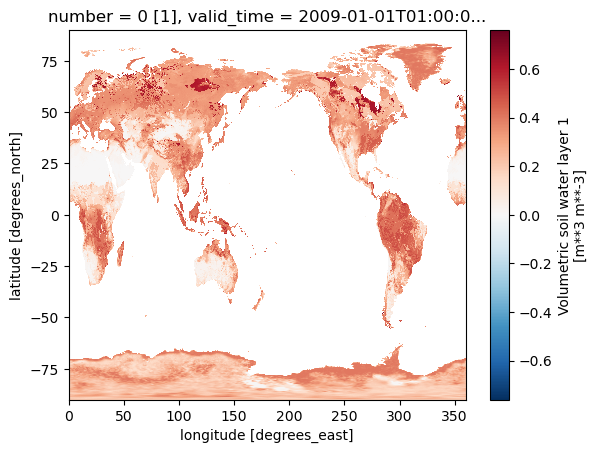

In [12]:
temp_file['swvl1'].plot()